In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import GPy
import random
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error as mse
from emukit.core import ParameterSpace, ContinuousParameter
from emukit.model_wrappers import GPyModelWrapper
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, \
                                                      NegativeLowerConfidenceBound, \
                                                      MaxValueEntropySearch, \
                                                      ProbabilityOfImprovement
from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [2]:
def myplot(y_true_list, y_pred_list,var_list, title_str_list, color_list,region):
    fig, axes = plt.subplots(1, 2, figsize=(5.5*2, 4.5))
    fs = 18
    
    for i in range(len(axes)):
        axes[i].scatter(y_true_list[i], y_pred_list[i], alpha = 0.6, c = color_list[i])
        axes[i].plot(region,region, 'k--', alpha=0.75, zorder=0)
        axes[i].errorbar(y_true_list[i],y_pred_list[i], yerr = var_list[i], ms = 0, 
                 ls = '', capsize = 2, alpha = 0.6,
                 color = 'gray', zorder = 0)
        axes[i].set_xlabel('Ground Truth', fontsize = fs)
        axes[i].set_ylabel('Prediction', fontsize = fs)
        axes[i].set_xlim(region)
        axes[i].set_ylim(region)
        rmse = mse(y_true_list[i],y_pred_list[i],squared=False)
        title = title_str_list[i] + " (RMSE = %.3f)"%rmse
        axes[i].set_title(title, fontsize = fs)
        axes[i].grid(True, linestyle='-.')

In [3]:
# 参数空间
Tip_Height_min, Tip_Height_max, Tip_Height_step = [0.5, 50, 0.5]
Tip_Height_var = np.arange(Tip_Height_min, Tip_Height_max+0.1*Tip_Height_step,Tip_Height_step)
Tip_Height_num = len(Tip_Height_var)

Dispense_Speed_AS_min, Dispense_Speed_AS_max, Dispense_Speed_AS_step = [20,500,10]
Dispense_Speed_AS_var = np.arange(Dispense_Speed_AS_min, Dispense_Speed_AS_max+0.1*Dispense_Speed_AS_step,Dispense_Speed_AS_step)
Dispense_Speed_AS_num = len(Dispense_Speed_AS_var)

Spin_Speed_AS_min, Spin_Speed_AS_max, Spin_Speed_AS_step = [500,7000,100]
Spin_Speed_var = np.arange(Spin_Speed_AS_min,Spin_Speed_AS_max+0.1*Spin_Speed_AS_step,Spin_Speed_AS_step)
Spin_Speed_num = len(Spin_Speed_var)

Volume_AS_min, Volume_AS_max, Volume_AS_step = [50,300,10]
Volume_AS_var = np.arange(Volume_AS_min, Volume_AS_max+0.1*Volume_AS_step, Volume_AS_step)
Volume_AS_num = len(Volume_AS_var)

Timing_AS_min, Timing_AS_max, Timing_AS_step = [2,25,1]
Timing_AS_var = np.arange(Timing_AS_min, Timing_AS_max+0.1*Timing_AS_step,Timing_AS_step)
Timing_AS_num = len(Timing_AS_var)

x_label=[
    'Tip_Height',
    'Dispense_Speed_AS',
    'Spin_Speed_AS',
    'Volume_AS',
    'Timing_AS'
]

var_array = [
    Tip_Height_var,
    Dispense_Speed_AS_var,
    Spin_Speed_var,
    Volume_AS_var,
    Timing_AS_var
]


def x_normalizer(X, var_array = var_array):
    
    def max_min_scaler(x, x_max, x_min):
        return (x-x_min)/(x_max-x_min)
    x_norm = []
    for x in (X):
           x_norm.append([max_min_scaler(x[i], 
                         max(var_array[i]), 
                         min(var_array[i])) for i in range(len(x))])
            
    return np.array(x_norm)

def x_denormalizer(x_norm, var_array = var_array):
    
    def max_min_rescaler(x, x_max, x_min):
        return x*(x_max-x_min)+x_min
    x_original = []
    for x in (x_norm):
           x_original.append([max_min_rescaler(x[i], 
                              max(var_array[i]), 
                              min(var_array[i])) for i in range(len(x))])

    return np.array(x_original)


def get_closest_array(suggested_x):
    
    def get_closest_value(given_value, array_list):
        absolute_difference_function = lambda list_value : abs(list_value - given_value)
        closest_value = min(array_list, key=absolute_difference_function)
        return closest_value
    
    var_list = var_array
    modified_array = []
    for x in suggested_x:
        modified_array.append([get_closest_value(x[i], var_list[i]) for i in range(len(x))])
    return np.array(modified_array)

In [4]:
data  = pd.read_excel('../高斯过程.xlsx',usecols=[i for i in range(1,10)]).dropna()
Data = data.values

X = Data[:,:5]

X_norm = x_normalizer(X)

a = np.linspace(0,7,8,dtype=int)
#ind = np.array(random.sample(a.tolist(),6),int)
test_index = [0,1,2] #ind#[0,1,2,3,4,5,6,7]    best  [23  6 20  4  1 19 17 22]
train_index = np.delete(a,test_index)#

index=5
Train_X = X_norm[train_index,:]
Test_X = X_norm[test_index,:]
# Train_y = Data[train_index,index]
# Test_y = Data[test_index,index]
# ss_y = StandardScaler()

ss_y = 600000
Train_y = Data[train_index,index]/ss_y
Test_y = Data[test_index,index]/ss_y


In [5]:
data

,Tip Height \n(mm) 0.5-50,Dispense Speed \n(ul/s) 20-500,AS Spin Speed \n(rpm) 500-7000,AS Volume \n(ul) 50-300,Timing AS\n (s) 2-25,PL Intensity ave,PL Intensity CV,Peak CV,PLQY
0,1.5,90.0,5600.0,50.0,12.0,175357.061097,0.173763,0.001152,0.337201
1,20.0,460.0,2300.0,220.0,25.0,178837.692437,0.309365,0.001924,0.333660
2,4.0,250.0,7000.0,300.0,22.0,324724.062188,0.119376,0.000455,0.325180
3,8.0,260.0,4900.0,100.0,5.0,251923.044783,0.227518,0.000707,0.321183
4,15.5,170.0,5100.0,70.0,7.0,228986.076923,0.144984,0.000439,0.335772
5,29.5,380.0,5800.0,100.0,13.0,241866.564743,0.123097,0.001060,0.310272
6,32.0,450.0,800.0,140.0,15.0,188744.000000,0.099226,0.000456,0.393455
7,50.0,200.0,1700.0,110.0,6.0,245398.692308,0.099245,0.000540,0.444454


In [6]:
Train_y

array([0.41987174, 0.38164346, 0.40311094, 0.31457333, 0.40899782])

In [7]:
rbf = GPy.kern.RBF(input_dim=5, variance=1., lengthscale=1.,ARD=True)
linear = GPy.kern.Linear(input_dim=5,ARD =True)
m52 = GPy.kern.sde_Matern52(input_dim=5,ARD =True)
m32 = GPy.kern.sde_Matern32(input_dim=5,ARD =True)
poly = GPy.kern.Poly(input_dim=5)
kernel = m32
model = GPy.models.GPRegression(Train_X,-Train_y.reshape(-1,1),kernel)

model.randomize()
model.optimize_restarts(num_restarts = 50)
model.optimize(messages=True)

y_pred_train = model.predict(Train_X)[0].ravel()
y_pred_test = model.predict(Test_X)[0].ravel()
var_train = np.sqrt(model.predict(Train_X)[1]).ravel()
var_test = np.sqrt(model.predict(Test_X)[1]).ravel()

 D:\Anaconda\lib\site-packages\GPy\kern\src\stationary.py:137: RuntimeWarning:overflow encountered in square
 D:\Anaconda\lib\site-packages\GPy\kern\src\stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/50, f = -7.8482215520830385
Optimization restart 2/50, f = -8.341599908979697
Optimization restart 3/50, f = -8.341596588497618
Optimization restart 4/50, f = -8.341585195314698
Optimization restart 5/50, f = -8.341600123611018
Optimization restart 6/50, f = -8.341600168007123
Optimization restart 7/50, f = -8.341598441493053
Optimization restart 8/50, f = -8.341582265744046
Optimization restart 9/50, f = -8.34159985329056
Optimization restart 10/50, f = -8.341599307553265
Optimization restart 11/50, f = -8.341592061201416
Optimization restart 12/50, f = -7.86637502470552
Optimization restart 13/50, f = -8.341598327691047
Optimization restart 14/50, f = -8.341600060175345
Optimization restart 15/50, f = -8.341599669456729
Optimization restart 16/50, f = -8.341599794673595
Optimization restart 17/50, f = -8.341595971141539
Optimization restart 18/50, f = -8.341599786427562
Optimization restart 19/50, f = -8.341600003101593
Optimization restart 20/50, f = -8.341600

 D:\Anaconda\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


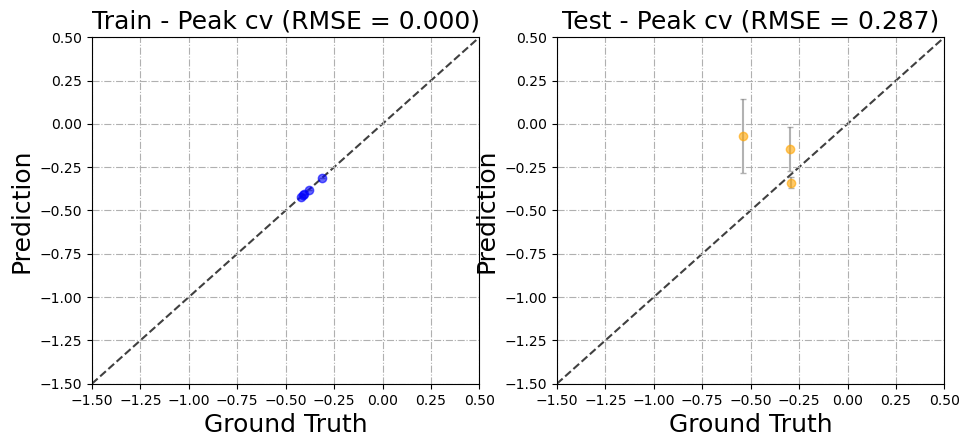

In [8]:
myplot([-Train_y,-Test_y],[y_pred_train,y_pred_test],[var_train,var_test],
       ["Train - Peak cv","Test - Peak cv"],
       ["blue","orange"],
      [-1.5,0.5])
#plt.savefig('result',dpi=1000)

In [9]:
X_normalize = x_normalizer(Data[:,:5])
Y_normalize = Data[:,5]/ss_y
m52 = GPy.kern.sde_Matern52(input_dim=5,ARD =True)
rbf =  GPy.kern.RBF(input_dim=5, variance=1., lengthscale=1.,ARD=True)
linear = GPy.kern.Linear(input_dim=5,ARD =True)
kernel = rbf
model = GPy.models.GPRegression(X_normalize,-Y_normalize.reshape(-1,1),kernel)

model.randomize()
model.optimize_restarts(num_restarts = 50)
model.optimize(messages=True)

Optimization restart 1/50, f = -10.480674306792125
Optimization restart 2/50, f = -12.99685204075536
Optimization restart 3/50, f = -12.996852320317235
Optimization restart 4/50, f = -10.480674260854432
Optimization restart 5/50, f = -12.996852360493502
Optimization restart 6/50, f = -12.996852191903525
Optimization restart 7/50, f = -10.480674160590105
Optimization restart 8/50, f = -10.74364977817947
Optimization restart 9/50, f = -12.99685227206228
Optimization restart 10/50, f = -12.996852085848566
Optimization restart 11/50, f = -10.480674288102627
Optimization restart 12/50, f = -12.996852233980967
Optimization restart 13/50, f = -10.480674257531494
Optimization restart 14/50, f = -12.99685236531052
Optimization restart 15/50, f = -10.480673983887279
Optimization restart 16/50, f = -10.48067428498625
Optimization restart 17/50, f = -12.996852153138672
Optimization restart 18/50, f = -10.480673957871215
Optimization restart 19/50, f = -10.480674124408413
Optimization restart 20/50

 D:\Anaconda\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


0.7803336195891495


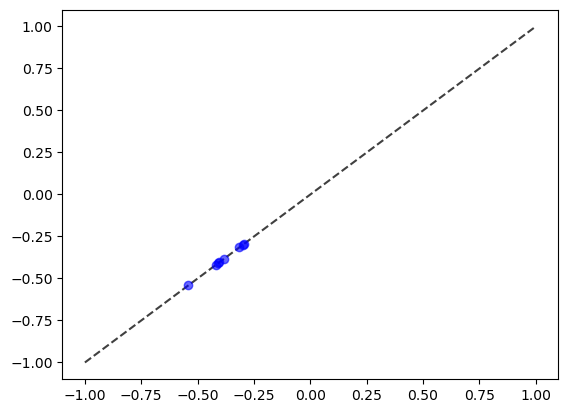

In [10]:
y_pred = model.predict(X_normalize)[0]
plt.scatter(-Y_normalize,y_pred,c='b',alpha=0.6)
plt.plot([-1,1],[-1,1], 'k--', alpha=0.75, zorder=0)
print(mse(Y_normalize,y_pred,squared=False))

In [11]:
parameter_space = ParameterSpace([ContinuousParameter('Tip_Height', 0-1/(Tip_Height_num-1)/2, 1+1/(Tip_Height_num-1)/2),
                                  ContinuousParameter('Dispense_Speed_AS', 0-1/(Dispense_Speed_AS_num-1)/2, 1+1/(Dispense_Speed_AS_num-1)/2),
                                  ContinuousParameter('Spin_Speed', 0-1/(Spin_Speed_num-1)/2, 1+1/(Spin_Speed_num-1)/2),
                                  ContinuousParameter('Volume_AS', 0-1/(Volume_AS_num-1)/2, 1+1/(Volume_AS_num-1)/2),
                                  ContinuousParameter('Timing_AS', 0-1/(Timing_AS_num-1)/2, 1+1/(Timing_AS_num-1)/2)
                                  
                                  ])
parameter_space.parameters

[ContinuousParameter(Tip_Height, -0.005050505050505051, 1.005050505050505),
 ContinuousParameter(Dispense_Speed_AS, -0.010416666666666666, 1.0104166666666667),
 ContinuousParameter(Spin_Speed, -0.007692307692307693, 1.0076923076923077),
 ContinuousParameter(Volume_AS, -0.02, 1.02),
 ContinuousParameter(Timing_AS, -0.021739130434782608, 1.0217391304347827)]

In [12]:
np.random.seed(1000)

objective_model = GPyModelWrapper(model)
bs = 1

beta = [0.1,1,10]
recommend_point = []
num = 3
for i in range(num):

    acquisition = NegativeLowerConfidenceBound(objective_model, beta = beta[i])#ExpectedImprovement(objective_model, jitter=beta[i])#NegativeLowerConfidenceBound(objective_model, beta = beta[i])#ExpectedImprovement(objective_model, jitter=.1)#NegativeLowerConfidenceBound(objective_model, beta = 1)

    bayesopt= BayesianOptimizationLoop(model=objective_model, 
                                       space=parameter_space, 
                                       acquisition=acquisition,
                                       batch_size = bs)


    X_new = bayesopt.candidate_point_calculator.compute_next_points(bayesopt.loop_state)

    recommend_point.append(get_closest_array(x_denormalizer(X_new,var_array)))
    
recommend_point_pd = pd.DataFrame(np.array(recommend_point).reshape(-1,5), columns = x_label)

rp = x_normalizer(np.array(recommend_point).reshape(num,5))
u = -ss_y*model.predict(rp)[0] #均值
sigma = ss_y*model.predict(rp)[1] #方差
pred = pd.DataFrame(np.append(u,sigma,axis=1),columns=['pred_mean','pred_sigma'])
final = pd.concat([recommend_point_pd, pred], axis=1)
final

1000000
Init point :  [0.11324954 0.4790688  0.03343347 1.01920693 0.96516776]
opt point :  (array([[0.11324955, 0.48423105, 0.03343347, 1.02      , 0.96752517]]), array([[-0.54314492]]))
acq_max =  [[0.54314492]]
1000000
Init point :  [0.87693287 0.48748631 0.40544023 1.017365   1.02132503]
opt point :  (array([[0.87693287, 0.47175044, 0.40544022, 1.02      , 1.02173913]]), array([[-0.54979358]]))
acq_max =  [[0.54979358]]
1000000
Init point :  [ 0.06830078 -0.00666404  0.71597691  1.00657569 -0.02060286]
opt point :  (array([[ 0.06830078, -0.01041667,  0.71597692,  1.02      , -0.02173913]]), array([[-0.81534355]]))
acq_max =  [[0.81534355]]


,Tip_Height,Dispense_Speed_AS,Spin_Speed_AS,Volume_AS,Timing_AS,pred_mean,pred_sigma
0,6.0,250.0,700.0,300.0,24.0,325244.419787,11.000363
1,44.0,250.0,3100.0,300.0,25.0,325041.513184,26.813353
2,4.0,20.0,5200.0,300.0,2.0,110404.389110,2177.230537


In [14]:
final.to_excel('Intensity ave2_gp.xlsx')

In [60]:
np.random.seed(1000)

objective_model = GPyModelWrapper(model)
bs = 10


acquisition = NegativeLowerConfidenceBound(objective_model, beta = 1)#ExpectedImprovement(objective_model, jitter=beta[i])#NegativeLowerConfidenceBound(objective_model, beta = beta[i])#ExpectedImprovement(objective_model, jitter=.1)#NegativeLowerConfidenceBound(objective_model, beta = 1)

bayesopt= BayesianOptimizationLoop(model=objective_model, 
                                   space=parameter_space, 
                                   acquisition=acquisition,
                                   batch_size = bs)


X_new = bayesopt.candidate_point_calculator.compute_next_points(bayesopt.loop_state)



1000000


 D:\Anaconda\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


Init point :  [0.88799325 0.93816605 1.00714266 0.01482975 0.88876728]
opt point :  (array([[0.88799325, 0.93816605, 1.00714266, 0.01482975, 0.88876728]]), array([[-0.5164956]]))
acq_max =  [[0.5164956]]
Init point :  [0.02719519 0.43417766 1.00714281 0.81891526 0.00123861]
opt point :  (array([[0.02719519, 0.43417766, 1.00714281, 0.81891526, 0.00123861]]), array([[-0.5164956]]))
acq_max =  [[0.5164956]]
Init point :  [0.4919932  0.47520592 1.00714274 0.02972576 1.01637217]
opt point :  (array([[0.4919932 , 0.47520592, 1.00714274, 0.02972576, 1.01637217]]), array([[-0.5164956]]))
acq_max =  [[0.5164956]]
Init point :  [0.01182767 0.64670903 1.00714191 0.06882496 0.8384769 ]
opt point :  (array([[0.01182767, 0.64670903, 1.00714191, 0.06882496, 0.8384769 ]]), array([[-0.5164956]]))
acq_max =  [[0.5164956]]
Init point :  [0.38831194 0.69011306 1.00714186 0.90674884 0.70010833]
opt point :  (array([[0.38831194, 0.69011306, 1.00714186, 0.90674884, 0.70010833]]), array([[-0.5164956]]))
acq_m

In [61]:
x = get_closest_array(x_denormalizer(X_new,var_array))
df_Xnew = pd.DataFrame(x, columns = x_label)
u = -ss_y*model.predict(x_normalizer(x))[0]
sigma = ss_y*model.predict(x_normalizer(x))[1]
pred = pd.DataFrame(np.append(u,sigma,axis=1),columns=['pred_mean','pred_sigma'])
final = pd.concat([df_Xnew, pred], axis=1)
final

,Tip_Height,Dispense_Speed_AS,Spin_Speed_AS,Volume_AS,Timing_AS,pred_mean,pred_sigma
0,44.5,461.0,7001.0,1.0,27.0,237483.785740,29251.854389
1,2.0,211.0,7001.0,241.0,1.0,237483.787187,29251.853965
2,25.0,231.0,7001.0,11.0,30.0,237483.786831,29251.854129
3,1.0,321.0,7001.0,21.0,25.0,237483.787717,29251.854080
4,19.5,341.0,7001.0,261.0,21.0,237483.786413,29251.853998
5,13.0,241.0,7001.0,191.0,10.0,237483.787082,29251.853907
6,8.0,151.0,7001.0,31.0,21.0,237483.787610,29251.853995
7,44.0,361.0,7001.0,171.0,14.0,237483.785592,29251.854177
8,5.5,101.0,7001.0,21.0,24.0,237483.787635,29251.854037
9,15.5,451.0,7001.0,11.0,10.0,237483.787387,29251.854047
